In [20]:
import torch
from torch import nn

from train import train, get_weighted_single_eval_pos_sampler
import priors
import encoders
import positional_encodings
import utils
import decoders
import tikzplotlib

from datasets import *
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import special  
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import numpy as np
from train import Losses

from datasets import get_biochem, get_2class_iris, get_heart
from copy import deepcopy
from sklearn import neighbors, datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from scripts import tabular_evaluation
from scripts import tabular_baselines
import datetime

In [21]:
import seaborn as sns
import pickle
from tqdm import tqdm
import os
import random
import numpy as np

from datasets import get_2class_wine, get_biochem, get_heart, get_2class_iris, get_breast_cancer, get_cov_type, get_amazon, get_svmlight, load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from priors.utils import order_by_y, normalize_by_used_features_f, plot_prior, plot_features
from utils import normalize_data
from priors.utils import trunc_norm_sampler_f, beta_sampler_f, gamma_sampler_f, uniform_sampler_f, zipf_sampler_f, scaled_beta_sampler_f, uniform_int_sampler_f
from scripts.tabular_baselines import *
from model_builder import get_default_spec, get_model
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score_per_method, calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
import openml

In [22]:
from notebook_utils import *

In [23]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [4]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..


In [5]:
def get_datasets(selector, task_type, suite='openml'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [17]:
[(i, test_datasets[i][0]) for i in range(len(test_datasets))]

[(0, 'balance-scale'),
 (1, 'mfeat-fourier'),
 (2, 'breast-w'),
 (3, 'mfeat-karhunen'),
 (4, 'mfeat-morphological'),
 (5, 'mfeat-zernike'),
 (6, 'cmc'),
 (7, 'credit-approval'),
 (8, 'credit-g'),
 (9, 'diabetes'),
 (10, 'tic-tac-toe'),
 (11, 'vehicle'),
 (12, 'eucalyptus'),
 (13, 'analcatdata_authorship'),
 (14, 'analcatdata_dmft'),
 (15, 'pc4'),
 (16, 'pc3'),
 (17, 'kc2'),
 (18, 'pc1'),
 (19, 'banknote-authentication'),
 (20, 'blood-transfusion-service-center'),
 (21, 'ilpd'),
 (22, 'qsar-biodeg'),
 (23, 'wdbc'),
 (24, 'cylinder-bands'),
 (25, 'dresses-sales'),
 (26, 'MiceProtein'),
 (27, 'car'),
 (28, 'steel-plates-fault'),
 (29, 'climate-model-simulation-crashes')]

# Setting params

In [128]:
eval_positions = [1000]
max_features = 100
bptt = 2000
selector = 'test'
base_path = os.path.join('.')
overwrite=False
max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
metric_used = tabular_metrics.auc_metric
baseline_methods = ['logistic', 'gp', 'knn', 'catboost', 'xgb', 'autosklearn2', 'autogluon']
task_type = 'multiclass'

In [7]:
suite = 'cc'
test_datasets = get_datasets('test',task_type, suite=suite)

In [8]:
clf_dict= {'gp': gp_metric
                , 'knn': knn_metric
                , 'catboost': catboost_metric
                , 'xgb': xgb_metric
                , 'logistic': logistic_metric
           , 'autosklearn': autosklearn_metric
             , 'autosklearn2': autosklearn2_metric
            , 'autogluon': autogluon_metric}

In [9]:
device = 'cpu'

def eval_method(task_type, method, dids, selector, eval_positions, max_time, metric_used, split_number, append_metric=True, fetch_only=False, verbose=False):
    
    dids = dids if type(dids) is list else [dids]
    
    for did in dids:

        ds = get_datasets(selector, task_type, suite=suite)

        ds = ds if did is None else ds[did:did+1]

        clf = clf_dict[method]

        time_string = '_time_'+str(max_time) if max_time else ''
        metric_used_string = '_'+tabular_baselines.get_scoring_string(metric_used, usage='') if append_metric else ''

        result = evaluate(datasets=ds
                          , model=clf
                          , method=method+time_string+metric_used_string
                          , bptt=bptt, base_path=base_path
                          , eval_positions=eval_positions
                          , device=device, max_splits=1
                          , overwrite=overwrite
                          , save=True
                          , metric_used=metric_used
                          , path_interfix=task_type
                          , fetch_only=fetch_only
                          , split_number=split_number
                          , verbose=verbose
                          , max_time=max_time)
    
    return result

# Evaluation

In [11]:
# DEBUG A METHOD
overwrite=True
r = eval_method(task_type, 'logistic', 26, 'test', eval_positions, 3, metric_used, 3)
#calculate_score_per_method(tabular_evaluation.auc_metric, 'roc', r, test_datasets_binary, [eval_positions[0]])
#calculate_score_per_method(tabular_evaluation.auc_metric, 'roc', r, test_datasets_multiclass[3:4], [-1])

Calculating splits<function logistic_metric at 0x7f3636e0a700> 540:   0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 11/10000 [00:03<47:35,  3.50trial/s, best loss: -0.9971263520777557]

Calculating splits<function logistic_metric at 0x7f3636e0a700> 540:   0%|          | 0/1 [00:03<?, ?it/s]


/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


saved results to /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_logistic_time_3_roc_auc_MiceProtein_540_1080_3.npy


In [16]:
test_datasets = get_datasets('test',task_type, suite=suite)

overwrite=True
jobs = [
    eval_method(task_type, m, did, selector, eval_positions, max_time, metric_used, split_number)
    for did in range(0, len(test_datasets))
    for selector in ['test']
    for m in baseline_methods
    for max_time in max_times
    for split_number in [1, 2, 3, 4, 5]
]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


  1%|          | 55/10000 [00:00<03:00, 55.10trial/s, best loss: -0.8863847736625514]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_1_roc_auc_balance-scale_312_624_1.npy


Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


  1%|          | 56/10000 [00:01<02:59, 55.48trial/s, best loss: -0.8772490470501223]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_1_roc_auc_balance-scale_312_624_2.npy


Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


  1%|          | 56/10000 [00:00<02:57, 56.08trial/s, best loss: -0.8500099553224553]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_1_roc_auc_balance-scale_312_624_3.npy


Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


  1%|          | 55/10000 [00:01<03:02, 54.62trial/s, best loss: -0.9098604269293926]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:01<?, ?it/s]
/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



saved results to /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_1_roc_auc_balance-scale_312_624_4.npy


Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 9/10000 [00:00<03:13, 51.64trial/s, best loss: -0.8254093583470825]

Calculating splits<function knn_metric at 0x7f3636e0aaf0> 312:   0%|          | 0/1 [00:00<?, ?it/s]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3318773/475731429.py", line 4, in <module>
    jobs = [
  File "/tmp/ipykernel_3318773/475731429.py", line 5, in <listcomp>
    eval_method(task, m, did, selector, eval_positions, max_time, metric_used, split_number)
  File "/tmp/ipykernel_3318773/551782496.py", line 18, in eval_method
    result = evaluate(datasets=ds
  File "/home/hollmann/prior-fitting-release/scripts/tabular_evaluation.py", line 118, in evaluate
    r = evaluate_position(X, y
  File "/home/hollmann/prior-fitting-release/scripts/tabular_evaluation.py", line 266, in evaluate_position
    _, outputs, best_configs = baseline_predict(model, eval_xs, eval_ys, categorical_feats
  File "/home/hollmann/prior-fitting-release/scripts/baseline_prediction_interface.py", line 24, in 

TypeError: object of type 'NoneType' has no len()

# Comparison

In [129]:
methods = baseline_methods + ['transformer']

In [65]:
pos = str(eval_positions[0])

global_results = {}
overwrite=False

for method in baseline_methods:
    for max_time in max_times:
        for split_number in range(1,5+1):
            global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)] = eval_method(task_type, method,  None, selector, 
                                                                                                                                    eval_positions, fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time, 

loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_balance-scale_312_624_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_mfeat-fourier_1000_2000_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_breast-w_349_698_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_mfeat-karhunen_1000_2000_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_mfeat-morphological_1000_2000_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_mfeat-zernike_1000_2000_1.npy
loading results from /work/dlclarge1/hollmann-PFN_Tabular/results/tabular/multiclass/results_knn_time_0.5_roc_auc_cmc_736_1472_1.npy
loadi

In [118]:
path_ = 'prior_tuning_result.pkl'

try:
    output = open(path_, 'rb')
    _, metrics, _, _, _, _ = CustomUnpickler(output).load()
except:
    output = open(path_, 'rb')
    _, metrics, _, _, _ = CustomUnpickler(output).load()
if isinstance(metrics, list):
    for i in range(1, len(metrics[1])+1):
        global_results['transformer_split_'+str(i)] = metrics[2][i-1]

In [119]:
# Verify integrity of results
for bl in set(global_results.keys()):
    if 'split_1' in bl:
        for ds in test_datasets:
            if f'{ds[0]}_ys_at_1000' not in global_results[bl]:
                continue
            match = (global_results[bl][f'{ds[0]}_ys_at_1000'] == global_results['transformer_split_1'][f'{ds[0]}_ys_at_1000']).float().mean()
            if not match:
                raise Exception("Not the same labels used")
            

In [120]:
limit_to = ''
calculate_score(tabular_metrics.auc_metric, 'roc', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.cross_entropy, 'cross_entropy', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.accuracy_metric, 'acc', global_results, test_datasets, eval_positions + [-1])
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='mean', limit_to=limit_to)
calculate_score(tabular_metrics.count_metric, 'count', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)

#### ROC and AUC plots from TabPFN Paper

In [121]:
def generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix):
    global_results_filtered_split = {**global_results_filtered}
    global_results_filtered_split = {k: global_results_filtered_split[k] for k in global_results_filtered_split.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number) in k or 'transformer_split_'+str(split_number) in k}

    matrix, matrix_stds = make_metric_matrix(global_results_filtered_split, methods, pos, metric_key, test_datasets)
    for method in methods:
        if time_matrix[method] > max_time * 2:
            matrix[method] = np.nan
        # = np.nan

    if metric_key == 'cross_entropy':
        matrix = -(matrix.fillna(-100))
    else:
        matrix = matrix.fillna(-1)
    return make_ranks_and_wins_table(matrix.copy())

In [122]:
%matplotlib inline

df_ = []
metric_keys = ['roc', 'cross_entropy', 'time']

for max_time in max_times:
    global_results_filtered = {**global_results}
    global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}
    
    time_matrix, _ = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)
    time_matrix = time_matrix.mean()
    
    if len(global_results_filtered) == 0:
        continue
        
    # Calculate ranks and wins per split
    for metric_key in metric_keys:
        for split_number in range(1,6):
            ranks, wins = generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix)

            for method in methods:
                method_ = method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='') if method != 'transformer' else method
                global_results[method_+'_split_'+str(split_number)]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[method]
                global_results[method_+'_split_'+str(split_number)]['mean_wins_'+metric_key+f'_at_{pos}'] = wins[method]
    
    #for method in global_results.keys():
    #    global_results[method]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[]
    
    avg_times = {}
    for method_ in methods:
        avg_times[method_] = []
        for split_number in range(1,6):
            if method_ != 'transformer':
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            else:
                method = method_+'_split_'+str(split_number)
            avg_times[method_] += [global_results[method][f'mean_time_at_{pos}']]
    avg_times = pd.DataFrame(avg_times).mean()
    
    for metric_key in metric_keys:
        for ranking in ['', 'rank_', 'wins_']:
            for method_ in methods:
                for split_number in range(1,6):
                    method = method_
                    if method_ != 'transformer':
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
                    else:
                        method = method_+'_split_'+str(split_number)

                    if global_results[method][f'sum_count_at_{pos}'] <= 29:
                        print('Warning not all datasets generated for '+method+' '+ str(global_results[method][f'sum_count_at_{pos}']))
                        
                    time = global_results[method]['mean_time'] if ranking == '' else max_time
                    time = max_time # Todo: This is not the real time
                    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    # For Roc AUC Plots
                    #if 'transformer' in method:
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                    #    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': max(avg_times), 'time': max(max_times), 'method': method_, 'split_number': split_number}]
                            
            
df_ = pd.DataFrame(df_)

In [130]:
metric_renamer = {'roc': 'ROC AUC', 'cross_entropy': 'Cross entropy'
                  , 'rank_roc': 'Mean ROC AUC Rank', 'rank_cross_entropy': 'Mean Cross entropy Rank'
                  , 'wins_roc': 'Mean ROC AUC Wins', 'wins_cross_entropy': 'Mean Cross entropy Wins'
                  , 'time': 'actual time taken'}
max_times_renamer = {0.5: "0.5s", 1: "1s", 5: "5s", 15: "15s", 30: "30s", 60: "1min", 300: "5min", 900: "15min", 3600: "1h", 14400: "4h"}

def make_tabular_results_plot(metric_key, exclude, max_times, df_, grouping=True):
    f, ax = plt.subplots(figsize=(7, 7))
    #ax.set(xscale="log")
    
    df_.loc[:, 'time_log'] = np.log10(df_.time)
    df_.loc[:, 'real_time_log'] = np.log10(df_.real_time)
    time_column = 'time_log' if grouping else 'real_time_log'

    sns.set_palette("tab10")
    for method in methods:
        if method in exclude or method=='transformer':
            continue
        df_method = df_[df_.method==method].copy()
        ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_method, marker='o', label=method, ax=ax)
    #sns.scatterplot(data=df_, x='time', y='metric', hue='method', ax=ax, style='method') #
    df_trans = df_[df_.method=='transformer']
    if time_column == 'real_time_log':
        # Removing dots for line for transformers
        df_trans = df_trans[np.logical_or(df_trans.real_time == df_trans.real_time.min(), df_trans.real_time == df_trans.real_time.max())]
        df_trans.loc[:, 'metric'+metric_key] = df_trans['metric'+metric_key].mean()
        df_trans.loc[:, time_column] = np.log(1) # Hacky code to get the right time from our measurements
    ax = sns.lineplot(time_column, 'metric'+metric_key, data=df_trans, linestyle='--', marker='o', ci="sd", ax=ax)
    
    #ax = sns.scatterplot(data = df_trans, x=time_column, y='metric'+metric_key, s=800, marker='*', color='grey') #
    #ax = plt.scatter(df_trans[time_column], df_trans['metric'+metric_key], s=600, marker=['*']) #
    
    if grouping:
        ax.set_xlabel("Time (s, requested, not actual)")
    else:
        ax.set_xlabel("Time taken")
    ax.set_ylabel(metric_renamer[metric_key])

    #ax.legend()
    
    times = np.log10(max_times)
    ax.set_xticks(times)
    ax.set_xticklabels([max_times_renamer[t] for t in max_times])
    
    #ax.legend([],[], frameon=False)
    
    return ax

In [131]:
df_absolute = df_.copy()

In [132]:
df_absolute = df_.copy()
df_absolute = df_absolute[np.logical_or(df_.method != 'autogluon', df_.time >= 30)] # Autogluon did not yield any useful results before 30s

knn_extend = df_absolute[np.logical_and(df_absolute.method=='knn', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400
df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()

knn_extend = df_absolute[np.logical_and(df_absolute.method=='logistic', df_absolute.time == 3600)].copy()
knn_extend['real_time'] = 14400
knn_extend['time'] = 14400

df_absolute = df_absolute.append(knn_extend, ignore_index=True).reindex()

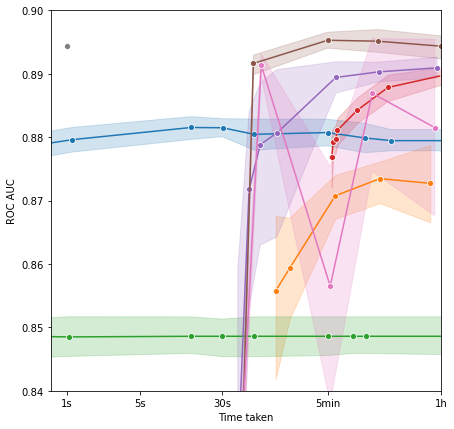

In [136]:
exclude=['tabnet']
#ax = make_tabular_results_plot('time', exclude=exclude)
ax = make_tabular_results_plot('roc', df_=df_absolute, exclude=exclude, grouping=False, max_times=[1, 5, 30, 60*5, 60*60])
ax.set_ylim([0.84, 0.9])
ax.set_xlim([np.log10(0.7), np.log10(3600)])
ax.legend([],[], frameon=False)

tikzplotlib.save(f'roc_over_time.tex', axis_height='5cm', axis_width='6cm', strict=True)

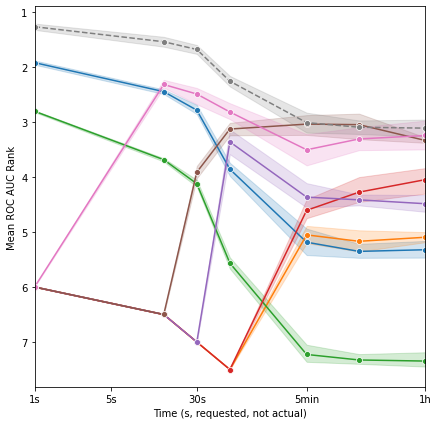

In [134]:
ax = make_tabular_results_plot('rank_roc', df_=df_[df_.time >= 1].copy(), exclude=['tabnet'], max_times=[1, 5, 30, 60*5, 60*60])
ax.invert_yaxis()
ax.set_xlim([np.log10(1.0), np.log10(3600)])
ax.legend([],[], frameon=False)
tikzplotlib.save(f'roc_raks_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

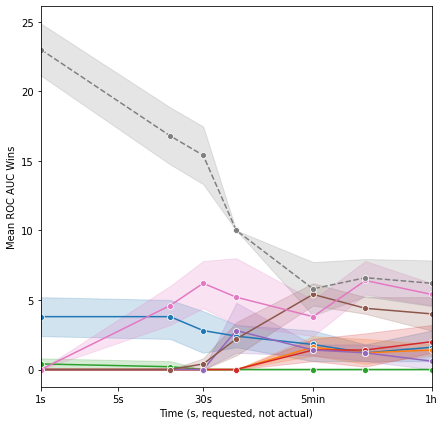

In [135]:
ax = make_tabular_results_plot('wins_roc', df_=df_[df_.time >= 1].copy(), exclude=exclude, max_times=[1, 5, 30, 60*5, 60*60])
ax.set_xlim([np.log10(1.0), np.log10(3600)])
ax.legend([],[], frameon=False)
tikzplotlib.save(f'roc_wins_tabular.tex', axis_height='5cm', axis_width='6cm', strict=True)

#### Big Table metrics

In [79]:
max_time = '3600'

In [80]:
global_results_filtered = {**global_results}
global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}


In [84]:
roc_matrix, roc_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'roc', test_datasets_multiclass_filtered)
acc_matrix, acc_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'acc', test_datasets_multiclass_filtered)
cross_entropy_matrix, cross_entropy_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'cross_entropy', test_datasets_multiclass_filtered)
time_matrix, time_matrix_stds = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets_multiclass_filtered)

roc_rank, rocs_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())
cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())

In [85]:
def wins_vs_idx(matrix, idx):
    wins_auc = np.array([[(matrix.values[:, j] < matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    ties_auc = np.array([[(matrix.values[:, j] == matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    losses_auc = np.array([[(matrix.values[:, j] > matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods)] for j in [idx]])
    
    return wins_auc, ties_auc, losses_auc

transformer_idx = np.where(roc_matrix.columns == 'transformer')[0][0]

wins_roc_vs_us, ties_roc_vs_us, losses_roc_vs_us = wins_vs_idx(roc_matrix, transformer_idx)
wins_acc_vs_us, ties_acc_vs_us, losses_acc_vs_us = wins_vs_idx(acc_matrix, transformer_idx)
wins_ce_vs_us, ties_ce_vs_us, losses_ce_vs_us = wins_vs_idx(-cross_entropy_matrix, transformer_idx)

In [86]:
def rename(table):
    return table.rename(columns=relabeler).T.rename(columns={'blood-transfusion-service-center': 'blood-transfus..'
                                                                , 'jungle_chess_2pcs_raw_endgame_complete': 'jungle\_chess..', 'bank-marketing': 'bank-market..'}).T

def get_suffix(i, k):
    suffix = ''
    suffix = suffix+'s' if test_datasets[i][5]['samples_capped'] == True else suffix
    suffix = suffix+'f' if test_datasets[i][5]['feats_capped'] == True else suffix
    suffix = suffix+'c' if test_datasets[i][5]['classes_capped'] == True else suffix
    suffix = '' if len(suffix) == 0 else f' [{suffix}]'
    
    return k + suffix

In [87]:
relabeler = {'transformer': 'Tabular PFN'
             , 'autogluon': 'Autogluon'
             , 'autosklearn2': 'Autosklearn2'
             
             , 'ridge':'Ridge'
             , 'gp': 'GP (RBF)'
             , 'bayes': 'BNN'
             , 'tabnet': 'Tabnet'
             , 'logistic': 'Log. Regr.'
             , 'knn': 'KNN'
             , 'catboost': 'Catboost'
            , 'xgb': 'XGB'}

In [88]:
table = roc_matrix.copy()
#table = roc_ovr_matrix.copy()
#table = acc_matrix.copy()
#table = cross_entropy_matrix.copy()

#table = table_acc
table.index = [get_suffix(i, k) for i, k in enumerate(table.index[0:table.shape[0]])]

table.loc['Wins AUC OVO'] = rocs_wins.values
#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Wins Acc.'] = acc_wins.values
#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Wins CE'] = cross_entropy_wins.values

table.loc['Win/T/L AUC vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_roc_vs_us[-1, :], ties_roc_vs_us[-1, :], losses_roc_vs_us[-1, :])]
table.loc['Win/T/L Acc vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_acc_vs_us[-1, :], ties_acc_vs_us[-1, :], losses_acc_vs_us[-1, :])]
table.loc['Win/T/L CE vs Us'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_ce_vs_us[-1, :], ties_ce_vs_us[-1, :], losses_ce_vs_us[-1, :])]

table.loc['Mean AUC OVO'] = roc_matrix.mean(skipna=True)
table.loc['Mean AUC OVO Stds'] = roc_matrix_stds.mean(skipna=True)

#table.loc['Mean AUC OVR'] = roc_ovr_matrix.mean(skipna=True)
table.loc['Mean Acc.'] = acc_matrix.mean()
table.loc['Mean Acc. Stds'] = acc_matrix_stds.mean(skipna=True)

#table.loc['Mean Bal. Acc.'] = balanced_acc_matrix.mean()
table.loc['Mean CE'] = cross_entropy_matrix.mean()
table.loc['Mean CE Stds'] = cross_entropy_matrix_stds.mean()

table.loc['M. rank AUC OVO'] = roc_rank.values
#table.loc['Mean rank AUC OVR'] = roc_ovr_rank.values
table.loc['Mean rank Acc.'] = acc_rank.values
#table.loc['Mean rank Bal. Acc.'] = balanced_acc_rank.values
table.loc['Mean rank CE'] = cross_entropy_rank.values

table.loc['Mean time (s)'] = time_matrix.mean()
table.loc['Mean time (s)', 'knn'] = 0.5
table.loc['Mean time (s)', 'logistic'] = 60

table = table[['knn', 'logistic', 'gp', 'catboost', 'xgb', 'autosklearn2', 'autogluon', 'transformer']]
rename(table).round(decimals=3).style.highlight_max(axis = 1, props= 'font-weight: bold;').format(precision=3)

,KNN,Log. Regr.,GP (RBF),Catboost,XGB,Autosklearn2,Autogluon,Tabular PFN
balance-scale,0.880,0.962,0.983,0.924,0.994,0.997,0.992,0.996
mfeat-fourier,0.970,0.976,0.923,0.982,0.980,0.983,0.984,0.982
breast-w,0.984,0.994,0.992,0.993,0.990,0.994,0.993,0.993
mfeat-karhunen,0.994,0.995,0.915,0.999,0.998,0.998,0.999,0.998
mfeat-morphological,0.951,0.964,0.959,0.963,0.961,0.967,0.970,0.968
mfeat-zernike,0.976,0.979,0.981,0.976,0.973,0.981,0.794,0.983
cmc,0.634,0.675,0.673,0.726,0.730,0.738,0.733,0.726
credit-approval,0.914,0.912,0.921,0.939,0.942,0.941,0.941,0.932
credit-g,0.726,0.760,0.778,0.782,0.785,0.793,0.794,0.790
diabetes,0.806,0.837,0.847,0.838,0.838,0.834,0.839,0.842


In [89]:
def bold_extreme_values(data, format_string="%.3g", max_=True):
    data = data.astype(float).round(3)
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

def to_str(data, format_string="%.3g"):
    formatted = data.apply(lambda x : format_string % x)
    return formatted

In [90]:
keys_max = ["Mean rank CE", "Mean rank Acc.", "Mean rank AUC OVO", "Mean rank AUC OVR", "Mean rank Bal. Acc.", "Mean AUC OVO", "Mean Acc."]
keys_max = ["Mean AUC OVO", "Mean Acc.", "Wins AUC OVO", "Wins Acc.", "Wins CE"]

keys_min = ["Mean rank CE", "Mean rank Acc.", "M. rank AUC OVO", "Mean CE"]

table_latex = rename(table).copy()

table_latex.iloc[0:30] = table_latex.iloc[0:30].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[["Mean time (s)"]] = table_latex.loc[["Mean time (s)"]].apply(lambda data : bold_extreme_values(data, format_string="%.4g", max_=False), axis=1)
table_latex.loc[keys_max] = table_latex.loc[keys_max].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[keys_min] = table_latex.loc[keys_min].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex.loc[['Mean CE Stds']] = table_latex.loc[['Mean CE Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
table_latex = table_latex.drop(['Mean CE Stds'])

table_latex.loc[['Mean Acc. Stds']] = table_latex.loc[['Mean Acc. Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
table_latex = table_latex.drop(['Mean Acc. Stds'])

table_latex.loc[['Mean AUC OVO Stds']] = table_latex.loc[['Mean AUC OVO Stds']].apply(lambda data : to_str(data, format_string="%.2g"),axis=1)
table_latex.loc['Mean AUC OVO'] = table_latex.loc['Mean AUC OVO'] + '$\pm$' + table_latex.loc['Mean AUC OVO Stds']
table_latex = table_latex.drop(['Mean AUC OVO Stds'])

table_latex
#print(table_latex.to_latex(escape=False))

,KNN,Log. Regr.,GP (RBF),Catboost,XGB,Autosklearn2,Autogluon,Tabular PFN
balance-scale,0.88,0.962,0.983,0.924,0.994,\textbf{0.997},0.992,0.996
mfeat-fourier,0.97,0.976,0.923,0.982,0.98,0.983,\textbf{0.984},0.982
breast-w,0.984,\textbf{0.994},0.992,0.993,0.99,\textbf{0.994},0.993,0.993
mfeat-karhunen,0.994,0.995,0.915,\textbf{0.999},0.998,0.998,\textbf{0.999},0.998
mfeat-morphological,0.951,0.964,0.959,0.963,0.961,0.967,\textbf{0.97},0.968
mfeat-zernike,0.976,0.979,0.981,0.976,0.973,0.981,0.794,\textbf{0.983}
cmc,0.634,0.675,0.673,0.726,0.73,\textbf{0.738},0.733,0.726
credit-approval,0.914,0.912,0.921,0.939,\textbf{0.942},0.941,0.941,0.932
credit-g,0.726,0.76,0.778,0.782,0.785,0.793,\textbf{0.794},0.79
diabetes,0.806,0.837,\textbf{0.847},0.838,0.838,0.834,0.839,0.842


In [91]:
print(table_latex.to_latex(escape=False))

\begin{tabular}{lllllllll}
\toprule
{} &              KNN &       Log. Regr. &         GP (RBF) &         Catboost &              XGB &             Autosklearn2 &                Autogluon &                Tabular PFN \\
\midrule
balance-scale                    &             0.88 &            0.962 &            0.983 &            0.924 &            0.994 &           \textbf{0.997} &                    0.992 &                      0.996 \\
mfeat-fourier                    &             0.97 &            0.976 &            0.923 &            0.982 &             0.98 &                    0.983 &           \textbf{0.984} &                      0.982 \\
breast-w                         &            0.984 &   \textbf{0.994} &            0.992 &            0.993 &             0.99 &           \textbf{0.994} &                    0.993 &                      0.993 \\
mfeat-karhunen                   &            0.994 &            0.995 &            0.915 &   \textbf{0.999} &            0.998 &

In [92]:
table_latex_small = table_latex.iloc[-len(keys_min+keys_max)-1-3:]
table_latex_small

,KNN,Log. Regr.,GP (RBF),Catboost,XGB,Autosklearn2,Autogluon,Tabular PFN
Wins AUC OVO,0,0,3,0,1,4,5,\textbf{10}
Wins Acc.,0,2,1,1,3,4,5,\textbf{11}
Wins CE,0,0,2,1,2,3,9,\textbf{12}
Win/T/L AUC vs Us,2/0/28,3/0/27,4/1/25,7/0/23,5/0/25,11/1/18,14/1/15,0/0/0
Win/T/L Acc vs Us,2/0/28,5/0/25,6/1/23,8/0/22,10/0/20,11/1/18,11/0/19,0/0/0
Win/T/L CE vs Us,0/0/30,1/0/29,4/0/26,5/0/25,7/0/23,8/0/22,14/0/16,0/0/0
Mean AUC OVO,0.849$\pm$0.015,0.879$\pm$0.011,0.873$\pm$0.027,0.89$\pm$0.011,0.891$\pm$0.011,\textbf{0.894}$\pm$0.01,0.882$\pm$0.039,\textbf{0.894}$\pm$0.0097
Mean Acc.,0.785$\pm$0.016,0.808$\pm$0.013,0.786$\pm$0.058,0.818$\pm$0.011,0.821$\pm$0.013,0.821$\pm$0.016,0.818$\pm$0.04,\textbf{0.826}$\pm$0.011
Mean CE,1.79$\pm$1.1,0.77$\pm$0.024,0.849$\pm$0.052,0.767$\pm$0.062,0.758$\pm$0.047,0.815$\pm$0.06,\textbf{0.73}$\pm$0.037,0.731$\pm$0.015
M. rank AUC OVO,7.43,5.4,5.3,4.07,4.53,3.13,3.32,\textbf{2.82}


In [438]:
print(table_latex_small.to_latex(escape=False))

\begin{tabular}{lllllllll}
\toprule
{} &              KNN &       Log. Regr. &         GP (RBF) &         Catboost &              XGB &               Autosklearn2 &                Autogluon &               Tabular PFN \\
\midrule
Wins AUC OVO      &                0 &                0 &                2 &                0 &                1 &                          5 &                        5 &                \textbf{8} \\
Wins Acc.         &                0 &                3 &                1 &                2 &                1 &                          4 &                        6 &               \textbf{10} \\
Wins CE           &                0 &                0 &                1 &                0 &                2 &                          1 &              \textbf{13} &                        11 \\
Win/T/L AUC vs Us &           2/0/28 &           3/0/27 &           3/1/26 &           7/1/22 &           5/0/25 &                    11/1/18 &                  13/1/16 &

In [1130]:
table_latex = table.copy()

table_latex.iloc[:-5] = table_latex.iloc[:-5].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.iloc[-5:-5] = table_latex.iloc[-5:-5].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex
#print(table_latex.to_latex(escape=False))

,logistic,gp,knn,catboost,xgb,autosklearn2,autogluon,tabnet,transformer
balance-scale,0.962,0.983,0.880,0.926,0.979,\textbf{0.997},0.993,0.918,0.996
mfeat-fourier,0.976,0.923,0.970,0.981,0.980,0.983,\textbf{0.985},0.899,0.980
breast-w,\textbf{0.994},0.992,0.984,0.993,0.992,\textbf{0.994},0.993,0.983,0.992
mfeat-karhunen,0.995,0.915,0.994,\textbf{0.999},0.998,0.998,\textbf{0.999},0.987,0.998
mfeat-morphological,0.964,0.959,0.951,0.963,0.961,0.967,\textbf{0.970},0.886,0.967
mfeat-zernike,0.979,0.981,0.976,0.976,0.974,0.981,\textbf{0.991},0.952,0.983
cmc,0.675,0.673,0.634,0.726,0.724,\textbf{0.738},0.734,0.659,0.727
credit-approval,0.912,0.921,0.914,0.939,0.940,0.941,\textbf{0.943},0.852,0.932
credit-g,0.760,0.778,0.726,0.782,0.780,\textbf{0.793},0.792,0.710,0.787
diabetes,0.837,\textbf{0.847},0.806,0.838,0.831,0.834,0.837,0.748,0.843


In [230]:
rename(table[-7:]).round(decimals=3).style.highlight_min(axis = 1, props= 'font-weight: bold;').format(precision=3)

,Log. Regr.,GP,KNN,Catboost,XGB,autosklearn,autosklearn_fast,h2o,h2o_fast,transformer,diff
Mean Bal. Acc.,0.461,0.593,0.628,0.684,0.645,0.683,0.671,0.693,0.701,0.669,0.015
Mean CE,0.989,0.787,1.223,0.808,0.844,1.011,0.910,0.935,0.833,0.820,-0.011
Mean rank AUC,7.889,6.708,8.375,4.208,4.639,4.139,4.708,4.278,5.014,5.042,-0.833
Mean rank AUC OVR,7.889,6.708,8.431,4.153,4.569,4.250,4.764,4.250,4.944,5.042,-0.889
Mean rank Acc.,8.069,7.319,7.583,4.111,4.556,3.764,4.403,4.458,5.139,5.597,-1.486
Mean rank Bal. Acc.,8.306,7.292,7.319,3.819,4.917,3.847,4.556,4.361,5.069,5.514,-1.694
Mean rank CE,5.500,5.500,5.500,5.500,5.500,5.500,5.500,5.500,5.500,5.500,0.000
